# Homework: Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design of was heavily inspired by [Torch](http://torch.ch) which is the most convenient neural network environment when the work involves defining new layers. 

This homework requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- homework_modules.ipynb
- homework_differentiation.ipynb

In [96]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from collections import defaultdict

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [97]:
# (re-)load layers
%run homework_modules.ipynb

Optimizer is implemented for you. 

In [98]:
def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            np.add(config['momentum'] * cur_old_grad, config['learning_rate'] * cur_dx, out = cur_old_grad)
            
            cur_x -= cur_old_grad
            i += 1 

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

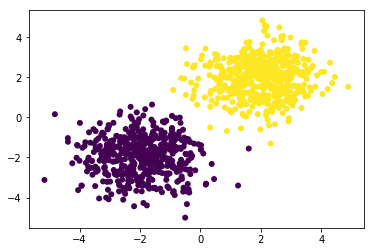

In [99]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [100]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [101]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [102]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

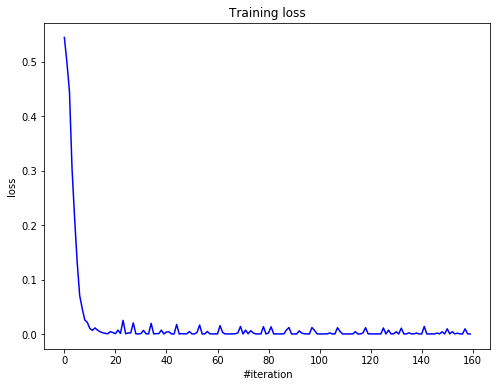

Current loss: 0.000035


In [103]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. Lets start with [cool visualization](http://scs.ryerson.ca/~aharley/vis/). The most beautiful demo is the second one, if you are not familiar with convolutions you can return to it in several lectures. 

In [104]:
import os
from sklearn.datasets import fetch_mldata

# Fetch MNIST dataset and create a local copy.
if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r') as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_mldata("mnist-original")
    X, y = mnist.data / 255.0, mnist.target
    np.savez('mnist.npz', X=X, y=y)

One-hot encode the labels first.

In [105]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score
binarizer = LabelBinarizer()
one_hot_y = binarizer.fit_transform(y)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Hint: logloss for MNIST should be around 0.5. 

In [112]:
def build_net(activation_fn, use_batch_norm=False, bn_alpha=0.9):
    net = Sequential()
    net.add(Linear(784, 512))
    if use_batch_norm:
        net.add(BatchNormalization(alpha=bn_alpha))
        net.add(ChannelwiseScaling(512))
    net.add(activation_fn)
    net.add(Linear(512, 512))
    if use_batch_norm:
        net.add(BatchNormalization(alpha=bn_alpha))
        net.add(ChannelwiseScaling(512))
    net.add(activation_fn)
    net.add(Linear(512, 10))
    net.add(LogSoftMax())
    criterion = ClassNLLCriterion()
    return net, criterion

def train(X, y, n_epochs, batch_size, net, criterion,
          optimizer_config, optimizer_state, lr_decay_fn=None):
    net.train()
    for i in range(n_epochs):
        for x_batch, y_batch in get_batches((X, y), batch_size):

            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)
            yield loss
        if lr_decay_fn is not None:
            lr_decay_fn(optimizer_config, i)
            

def evaluate(X, y_one_hot, net, criterion, label_binarizer):
    net.evaluate()
    net.zeroGradParameters()
    predictions_one_hot = net.forward(X)
    loss = criterion.forward(predictions_one_hot, y_one_hot)
    predictions = label_binarizer.inverse_transform(predictions_one_hot)
    true = label_binarizer.inverse_transform(y_one_hot)
    accuracy = accuracy_score(predictions, true)
    return loss, accuracy

def update_graph(all_losses, log_scale=False):
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))     
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    if log_scale:
        plt.yscale('log')
    for label in all_losses:
        losses = all_losses[label]
        plt.plot(losses, label=label)
    plt.legend()
    plt.show()
    print("Last losses:")
    for label in all_losses:
        losses = all_losses[label]
        print(label, losses[-1])

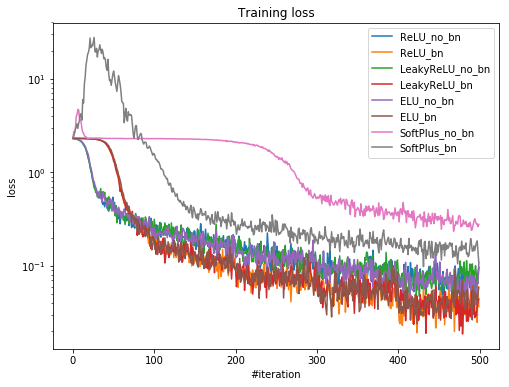

Last losses:
ReLU_no_bn 0.0961532178855
ReLU_bn 0.0366390191965
LeakyReLU_no_bn 0.096160139565
LeakyReLU_bn 0.0440208369463
ELU_no_bn 0.106713516729
ELU_bn 0.058765390602
SoftPlus_no_bn 0.277100772732
SoftPlus_bn 0.108426736237


In [114]:
use_bn = [False, True]
activation_fns = [ReLU(), LeakyReLU(), ELU(alpha=0.01), SoftPlus()]
all_losses = defaultdict(list)

for activation_fn in activation_fns:
    for bn_flag in use_bn:
        label = f"{activation_fn}_" + ("bn" if bn_flag else "no_bn")
        print(label)
        net, criterion = build_net(activation_fn, use_batch_norm=bn_flag)
        for idx, loss in enumerate(train(X, one_hot_y, n_epochs=5, batch_size=700, net=net, criterion=criterion,
                                   optimizer_config={'learning_rate': 1e-1, 'momentum': 0.9}, optimizer_state={})):
            all_losses[label].append(loss)
            if (idx + 1) % 20 == 0:
                update_graph(all_losses, log_scale=True)

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

ReLU, ELU and LeakyReLU work pretty much the same, as it can be seen on the graph. 
BatchNormalization does help - it improves convergence time.

Net with SoftPlus converges incredibly slow, slower than nets with other activations (BN or no BN).
In that case you can't get away without BatchNormalization.

**Finally**, use all your knowledge to build a super cool model on this dataset, do not forget to split dataset into train and validation. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [107]:
# Your code goes here. ################################################
def build_best_net(activation_fn, use_batch_norm=False, bn_alpha=0.9):
    net = Sequential()
    net.add(Linear(784, 512))
    if use_batch_norm:
        net.add(BatchNormalization(alpha=bn_alpha))
        net.add(ChannelwiseScaling(512))
    net.add(activation_fn)
    net.add(Dropout(0.5))
    net.add(Linear(512, 512))
    if use_batch_norm:
        net.add(BatchNormalization(alpha=bn_alpha))
        net.add(ChannelwiseScaling(512))
    net.add(activation_fn)
    net.add(Linear(512, 10))
    net.add(LogSoftMax())
    criterion = ClassNLLCriterion()
    return net, criterion
def lr_decay_fn(optimizer_config, epoch_idx):
    optimizer_config["learning_rate"] /= 2

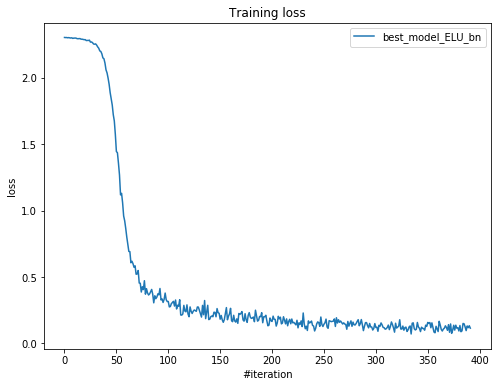

Last losses:
best_model_ELU_bn 0.114222095086
0.973857142857


In [110]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, one_hot_y, test_size=0.3)
net, criterion = build_best_net(ELU(alpha=0.01), use_batch_norm=True)
losses = defaultdict(list)
for train_loss in train(X_train, y_train, n_epochs=4, batch_size=500, net=net, criterion=criterion,
                        optimizer_config={'learning_rate': 1e-1, 'momentum': 0.9}, optimizer_state={},
                        lr_decay_fn=None):
    label = "best_model_ELU_bn"
    losses[label].append(train_loss)
    update_graph(losses)
eval_loss, accuracy = evaluate(X_test, y_test, net, criterion, binarizer)
print(accuracy)

Print here your accuracy. It should be around 90%.

In [111]:
print(accuracy)

0.973857142857


# Autoencoder

Now we are going to build a cool model, named autoencoder. The aim is simple: **encode** the data to a lower dimentional representation. Why? Well, if we can **decode** this representation back to original data with "small" reconstuction loss then we can store only compressed representation saving memory. But the most important thing is -- we can reuse trained autoencoder for classification. 
<img src="autoencoder.png">

Picture from this [site](http://multithreaded.stitchfix.com/blog/2015/09/17/deep-style/).

Now implement an autoencoder:

Build it such that dimetionality inside autoencoder changes like that: 

$$784 \text{ (data)} -> 512 -> 256 -> 128 -> 30 -> 128 -> 256 -> 512 -> 784$$

Use `MSECriterion` to score the reconstruction. Use `BatchNormalization` (followed by `ChannelwiseScaling` as usual) between `Linear` and `ReLU`. You may not use nonlinearity in bottleneck layer.

You may train it for 9 epochs with batch size = 256, initial lr = 0.1 droping by a factor of 2 every 3 epochs. The reconstruction loss should be about 6.0 and visual quality decent already.
Do not spend time on changing architecture, they are more or less the same. 

In [56]:
# Your code goes here. ################################################
def lr_decay(optimizer_config, epoch_idx):
    if (epoch_idx + 1) % 3 == 0:
        optimizer_config["learning_rate"] /= 2

def add_building_block(net, n_in, n_out, use_bn=True, activation=True, bn_alpha=0.9):
    net.add(Linear(n_in, n_out))
    if use_bn:
        net.add(BatchNormalization(bn_alpha))
        net.add(ChannelwiseScaling(n_out))
    if activation:
        net.add(ReLU())
    return net
    
def build_autoencoder(bn_alpha=0.9):
    net = Sequential()
    net = add_building_block(net, 784, 512)
    net = add_building_block(net, 512, 256)
    net = add_building_block(net, 256, 128)
    net = add_building_block(net, 128, 30, activation=False, use_bn=False)
    net = add_building_block(net, 30, 128)
    net = add_building_block(net, 128, 256)
    net = add_building_block(net, 256, 512)
    net = add_building_block(net, 512, 784, use_bn=False)
    criterion = MSECriterion()
    return net, criterion


In [57]:
autoencoder, criterion = build_autoencoder()

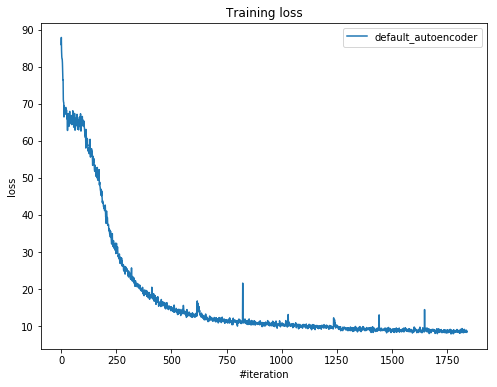

Last losses:
default_autoencoder 8.54052255851
current lr: 0.00125


In [58]:
all_losses = defaultdict(list)
optimizer_config={'learning_rate': 5e-3, 'momentum': 0.9}
for idx, train_loss in enumerate(train(X_train, X_train, n_epochs=9, batch_size=256, net=autoencoder, criterion=criterion,
                                       optimizer_config=optimizer_config, optimizer_state={},
                                       lr_decay_fn=lr_decay)):
    all_losses["default_autoencoder"].append(train_loss)
    if (idx + 1) % 20 == 0:
        update_graph(all_losses)
        print("current lr:", optimizer_config["learning_rate"])

Some time ago NNs were a lot poorer and people were struggling to learn deep models. To train a classification net people were training autoencoder first (to train autoencoder people were pretraining single layers with [RBM](https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine)), then substituting the decoder part with classification layer (yeah, they were struggling with training autoencoders a lot, and complex techniques were used at that dark times). We are going to this now, fast and easy.  

# Freezed encoder from autoencoder + classification net

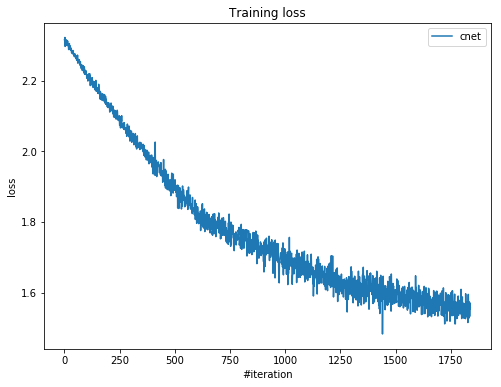

Last losses:
cnet 1.55705626913


In [60]:
# Extract inner representation for train and validation, 
# you should get (n_samples, 30) matrices
# Your code goes here. ################################################
embedding_train, embedding_test = X_train, X_test
for i in range(len(autoencoder.modules) // 2):
    embedding_train = autoencoder[i].forward(embedding_train)
    embedding_test = autoencoder[i].forward(embedding_test)
    

# Now build a logistic regression or small classification net
cnet = Sequential()
cnet.add(Linear(30, 10))
cnet.add(LogSoftMax())

# Learn the weights
# Your code goes here. ################################################
optimizer_config={'learning_rate': 1e-2, 'momentum': 0.9}
cnet_losses = defaultdict(list)
for idx, train_loss in enumerate(train(embedding_train, y_train, n_epochs=9, batch_size=256,
                                       net=cnet, criterion=ClassNLLCriterion(),
                                       optimizer_config=optimizer_config, optimizer_state={},
                                       lr_decay_fn=lr_decay)):
    
    cnet_losses["cnet"].append(train_loss)
    if (idx + 1) % 20 == 0:
        update_graph(cnet_losses)

In [61]:
loss, accuracy = evaluate(embedding_test, y_test, net=cnet,
                          criterion=ClassNLLCriterion(), label_binarizer=binarizer)

In [62]:
accuracy

0.7788571428571428

# Hybrid net: pretrained encoder from autoencoder + pretrained classification layers trained together

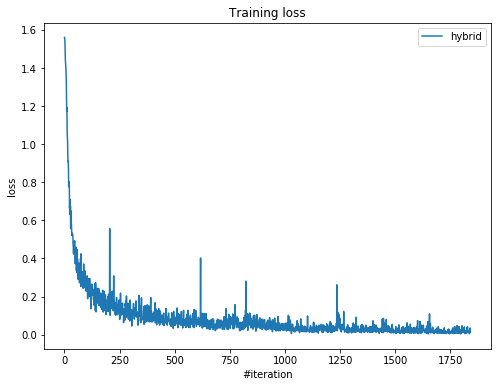

Last losses:
hybrid 0.0188123790567


In [63]:
# Now chop off decoder part
# (you may need to implement `remove` method for Sequential container) 
# Your code goes here. ################################################
hybrid_net = Sequential()
for i in range(len(autoencoder.modules) // 2):
    hybrid_net.add(autoencoder[i])

# And add learned layers ontop.
hybrid_net.add(cnet[0])
hybrid_net.add(cnet[1])

print(hybrid_net)

# Now optimize whole model
# Your code goes here. ################################################
optimizer_config={'learning_rate': 1e-2, 'momentum': 0.9}
hybrid_losses = defaultdict(list)
for idx, train_loss in enumerate(train(X_train, y_train, n_epochs=9, batch_size=256,
                                       net=hybrid_net, criterion=ClassNLLCriterion(),
                                       optimizer_config=optimizer_config, optimizer_state={})):
    hybrid_losses["hybrid"].append(train_loss)
    if idx % 20 == 0:
        update_graph(hybrid_losses)

In [64]:
loss, accuracy = evaluate(X_test, y_test, net=hybrid_net,
                          criterion=ClassNLLCriterion(), label_binarizer=binarizer)

In [65]:
accuracy

0.98034285714285718

# Straightforward way: train hybrid model from scratch

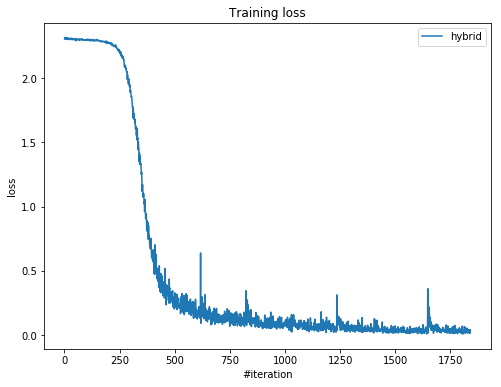

Last losses:
hybrid 0.0183993453229


In [66]:
sf_net = Sequential()
sf_net = add_building_block(sf_net, 784, 512)
sf_net = add_building_block(sf_net, 512, 256)
sf_net = add_building_block(sf_net, 256, 128)
sf_net = add_building_block(sf_net, 128, 30, activation=False, use_bn=False)
sf_net.add(Linear(30, 10))
sf_net.add(LogSoftMax())
optimizer_config={'learning_rate': 1e-2, 'momentum': 0.9}
sf_losses = defaultdict(list)
for idx, train_loss in enumerate(train(X_train, y_train, n_epochs=9, batch_size=256,
                                       net=sf_net, criterion=ClassNLLCriterion(),
                                       optimizer_config=optimizer_config, optimizer_state={})):
    sf_losses["hybrid"].append(train_loss)
    if idx % 20 == 0:
        update_graph(sf_losses)

In [67]:
loss, accuracy = evaluate(X_test, y_test, net=sf_net,
                          criterion=ClassNLLCriterion(), label_binarizer=binarizer)

In [68]:
accuracy

0.97548571428571429

* What do you think, does it make sense to build real-world classifiers this way ? Did it work better for you than a straightforward one? Looks like it was not the same ~8 years ago, what has changed beside computational power? 

Straightforward model had the same architecture as hybrid one, but its parts weren't pretrained. Nevertheless it showed accuracy similar to that of a hybrid model. Therefore, as it is much easier to train model end-to-end rather than with pretraining different parts (in terms of setup), it doesn't make a lot of sense to pretrain autoencoder, then freeze its weights and train classifier and then finetune them together. It might make sense to freeze weights of autoencoder and build classifier on top of representations given by encoder (like with convnets), but in our case representations returned by encoder apparently weren't good enough.

In 8 years new gradient-based optimization methods were proposed (momentum, adam), that made it possible to train deeper architectures. Also, after that deep learning frameworks started to appear, where all basic layers, optimization methods and loss functions were already implemented.

Run PCA with 30 components on the *train set*, plot original image, autoencoder and PCA reconstructions side by side for 10 samples from *validation set*.
You'll probably need to use the following snippet to make autoencoder examples look comparable.

(10, 30)


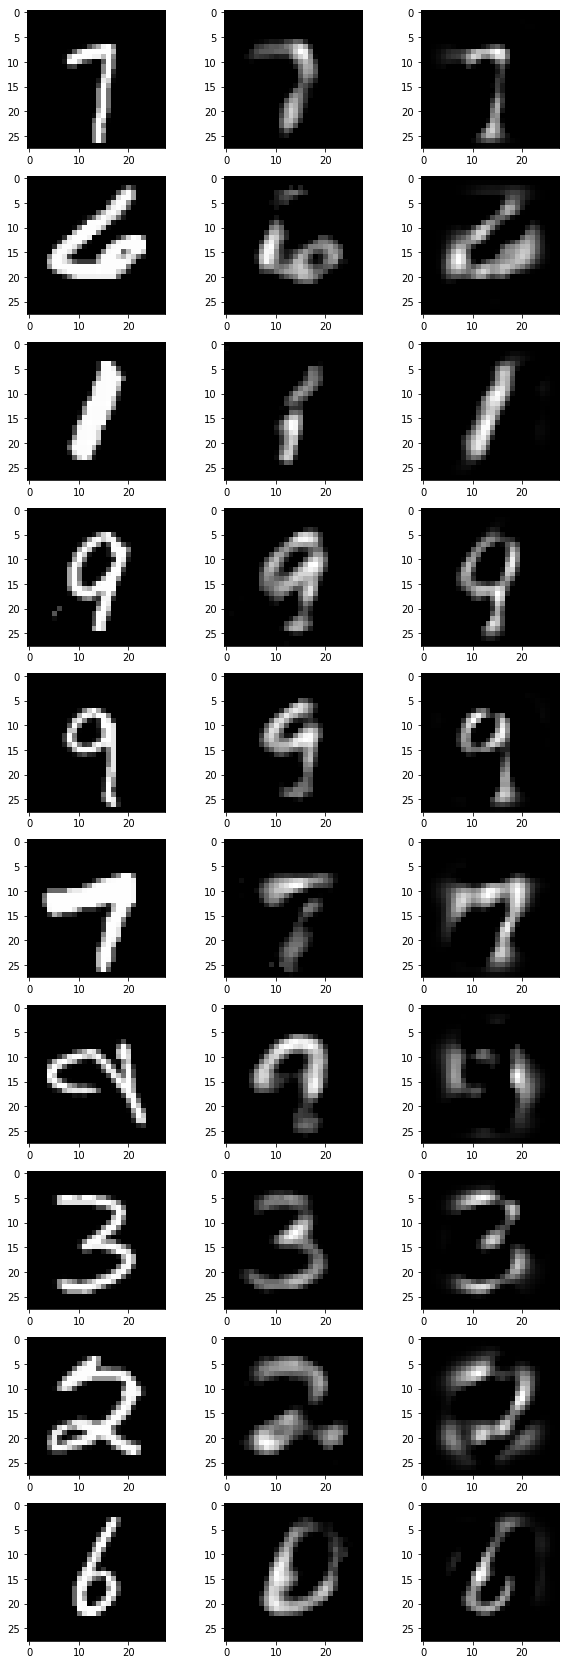

In [95]:
# np.clip(prediction,0,1)
from sklearn.decomposition import PCA
pca = PCA(n_components=30)
pca.fit(X_train)
chosen_samples = np.random.choice(len(X_test), size=10)
pred_pca = pca.transform(X_test[chosen_samples])
print(pred_pca.shape)
pred_autoencoder = autoencoder.forward(X_test[chosen_samples])
fig, axarray = plt.subplots(10, 3, figsize=(10, 30))
for idx, (pca_coefs, autoenc_, true_) in enumerate(zip(pred_pca, pred_autoencoder, X_test[chosen_samples])):
    axarray[idx][0].imshow(true_.reshape(28, 28), cmap="gray")
    axarray[idx][1].imshow(autoenc_.reshape(28, 28), cmap="gray")
    pca_prediction = np.zeros(X_test[0].shape)
    for coef, component in zip(pca_coefs, pca.components_):
        pca_prediction += coef * component
    pca_prediction = np.clip(pca_prediction, 0, 1)
    axarray[idx][2].imshow(pca_prediction.reshape(28, 28), cmap="gray")
plt.show()

I can't say that PCA is better than autoencoder or the other way around. I think pictures look kind of the same, but they have different artifacts due to model limitations.

Pictures produced by PCA have ghosts of other numbers, due to the fact that picture produced by PCA is a linear combination of principal components found in all of the training images. 

And pictures from autoencoder sometimes show wrong numbers, because number on original picture looked similar to that other number and autoencoder produces similar representations for them.